Use the environment found on GCP at `/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm`

In [1]:
#enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload


In [2]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split
import random

# import from scfair-reproducibility
from scfair_reproducibility.benchmark_VAE.vi import VI
from scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

# other methods
# import cpa
# from data.biolord_dev.src import biolord

/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [23]:
from dis2p.dis2pvi import *
from dis2p.dis2pvae import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *


# prepare data: Neurips 2021 

https://openproblems.bio/events/2021-09_neurips/ 

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122


Data downloaded with `wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fmultiome%5FBMMC%5Fprocessed%2Eh5ad%2Egz`

Define function to convert covariate names to numerical values

In [8]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

Load and subsample the heart atlas dataset from Litvinukova et al. Nature 2020

In [9]:
adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/dis2pm_dev/data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
print(adata)

/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


In [10]:
print(adata.var["feature_types"].value_counts())

feature_types
ATAC    116490
GEX      13431
Name: count, dtype: int64


In [11]:
print(adata.obs["batch"].value_counts())

batch
s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: count, dtype: int64


In [12]:
print(adata.obs["DonorID"].value_counts())

DonorID
15078    18467
19593     9876
18303     8604
28483     6781
10886     6740
12710     6111
16710     4895
13272     4325
11466     1771
28045     1679
Name: count, dtype: int64


In [15]:
adata = adata[:,adata.var["feature_types"]=="GEX"]
print(adata)

View of AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


In [16]:
# preprocess dataset
# adata.var_names_make_unique()
# print(adata.shape)
# print(adata.var["feature_types"].value_counts())
# sc.pp.filter_genes(adata, min_cells=int(adata.shape[0] * 0.05))
# print(adata.shape)
# print(adata.var["feature_types"].value_counts())

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'neurips2021_hvg_dis2p'

# specify attributes
cats = ['DonorID', 'batch', 'Ethnicity']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [17]:
print(adata.var["feature_types"].value_counts())

feature_types
GEX    1200
Name: count, dtype: int64


In [18]:
print(adata.var["feature_types"])

LINC01128     GEX
SMIM1         GEX
ESPN          GEX
MFN2          GEX
KAZN          GEX
             ... 
AL683813.1    GEX
FGF13         GEX
SLC6A8        GEX
MPP1          GEX
CLIC2         GEX
Name: feature_types, Length: 1200, dtype: category
Categories (1, object): ['GEX']


# train model: dis2p(n_cf=1)

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [25]:
# train params
epochs = 40 #400
batch_size = 256 #7 #128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 50
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
# try:
#     model = Dis2pmVI.load(f"{pre_path}/{model_name}", adata=adata)

# # trains the model (if not trained before) and save it into: pre_path + model_name
# except:

Dis2pVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
print(adata)
model = Dis2pVI(adata, 
                n_layers=n_layers)
model.train( **train_dict,)
model.save(f"{pre_path}/{model_name}")

AnnData object with n_obs × n_vars = 69249 × 1200
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'DonorID_idx', 'batch_idx', 'Ethnicity_idx', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 1/40:   0%|                                                                                                                                                                                                                                                        | 0/40 [00:00<?, ?it/s]

/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 36/40:  88%|▉| 35/40 [46:48<03:39, 43.97s/it, v_num=1, loss_validation=2.48e+3, x_0_validation=375, x_1_validation=423, x_2_validation=424, x_3_validation=428, rec_x_cf_validation=642, z_1_validation=29.5, z_2_validation=24.2, z_3_validation=26.5, ce_validation=1.19, acc_validationEpoch 00036: reducing learning rate of group 0 to 6.0000e-04.
Epoch 40/40: 100%|█| 40/40 [50:17<00:00, 42.72s/it, v_num=1, loss_validation=2.48e+3, x_0_validation=374, x_1_validation=427, x_2_validation=432, x_3_validation=425, rec_x_cf_validation=636, z_1_validation=28, z_2_validation=24.3, z_3_validation=26.2, ce_validation=1.19, acc_validation=0

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|█| 40/40 [50:17<00:00, 75.45s/it, v_num=1, loss_validation=2.48e+3, x_0_validation=374, x_1_validation=427, x_2_validation=432, x_3_validation=425, rec_x_cf_validation=636, z_1_validation=28, z_2_validation=24.3, z_3_validation=26.2, ce_validation=1.19, acc_validation=0


# Load previous model

In [ ]:
today

In [17]:
# # train params
# day = '2023-12-06'

# # train params
# epochs = 5 #400
# batch_size = 256 #7 #128
# cf_weight = 1
# beta = 1
# clf_weight = 50
# adv_clf_weight = 10
# adv_period = 1
# n_cf = 1

# # architecture params
# n_layers=1

# train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
#               'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
#               'adv_period': adv_period, 'n_cf': n_cf}

# module_name = 'dis2pmPoisson'
# pre_path = f'models/{module_name}'
# if not os.path.exists(pre_path):
#     os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())


dict_keys(['loss_validation', 'x_0_validation', 'x_1_validation', 'x_2_validation', 'x_3_validation', 'rec_x_cf_validation', 'z_1_validation', 'z_2_validation', 'z_3_validation', 'ce_validation', 'acc_validation', 'f1_validation', 'adv_ce_validation', 'adv_acc_validation', 'adv_f1_validation', 'loss_train', 'x_0_train', 'x_1_train', 'x_2_train', 'x_3_train', 'rec_x_cf_train', 'z_1_train', 'z_2_train', 'z_3_train', 'ce_train', 'acc_train', 'f1_train', 'adv_ce_train', 'adv_acc_train', 'adv_f1_train'])


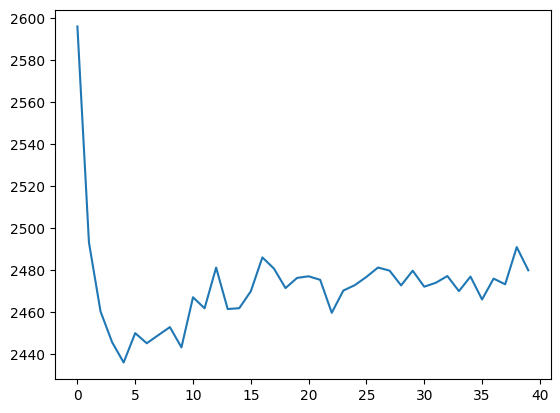

In [26]:
import matplotlib.pyplot as plt 
print(model.history.keys())

plt.plot(model.history['loss_validation'])


In [27]:
#plt.plot(model.history['loss_validation'])
print(model.history.keys())

dict_keys(['loss_validation', 'x_0_validation', 'x_1_validation', 'x_2_validation', 'x_3_validation', 'rec_x_cf_validation', 'z_1_validation', 'z_2_validation', 'z_3_validation', 'ce_validation', 'acc_validation', 'f1_validation', 'adv_ce_validation', 'adv_acc_validation', 'adv_f1_validation', 'loss_train', 'x_0_train', 'x_1_train', 'x_2_train', 'x_3_train', 'rec_x_cf_train', 'z_1_train', 'z_2_train', 'z_3_train', 'ce_train', 'acc_train', 'f1_train', 'adv_ce_train', 'adv_acc_train', 'adv_f1_train'])


In [28]:
for i in model.history.keys():
    print(i)

loss_validation
x_0_validation
x_1_validation
x_2_validation
x_3_validation
rec_x_cf_validation
z_1_validation
z_2_validation
z_3_validation
ce_validation
acc_validation
f1_validation
adv_ce_validation
adv_acc_validation
adv_f1_validation
loss_train
x_0_train
x_1_train
x_2_train
x_3_train
rec_x_cf_train
z_1_train
z_2_train
z_3_train
ce_train
acc_train
f1_train
adv_ce_train
adv_acc_train
adv_f1_train


In [29]:

# Z_0
adata.obsm[f'dis2p_Z_0_gex'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}_gex'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}_gex'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)  


In [30]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)


---UMAP for dis2p_Z_0_gex ---


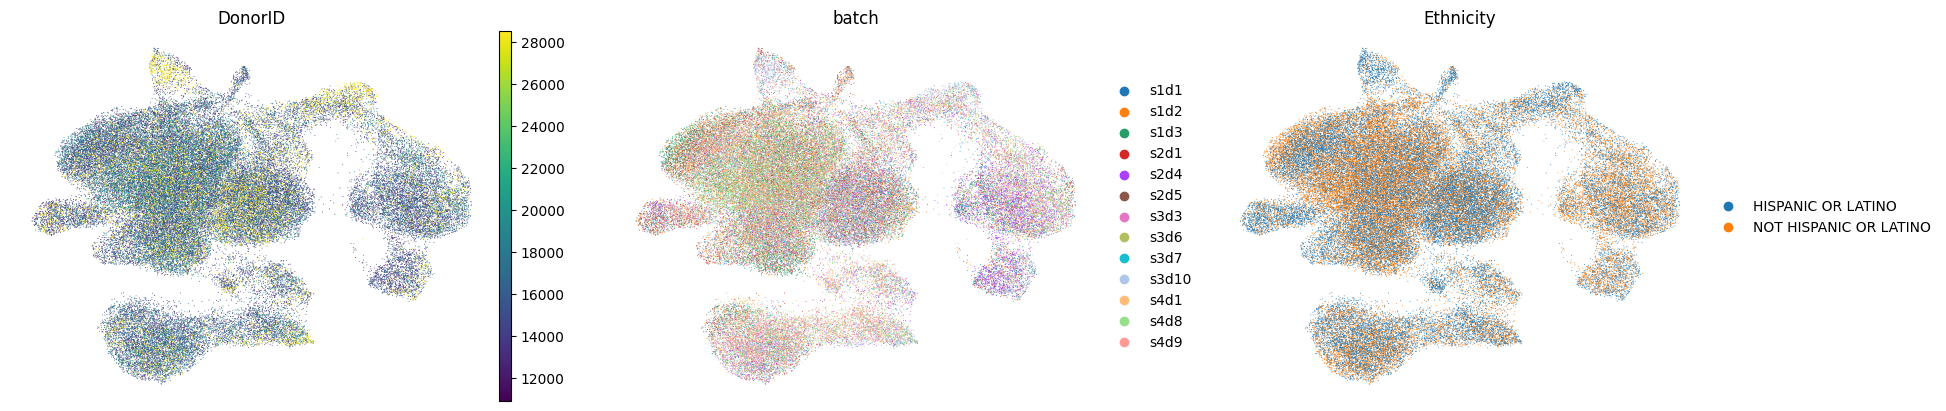

---UMAP for dis2p_Z_1_gex ---


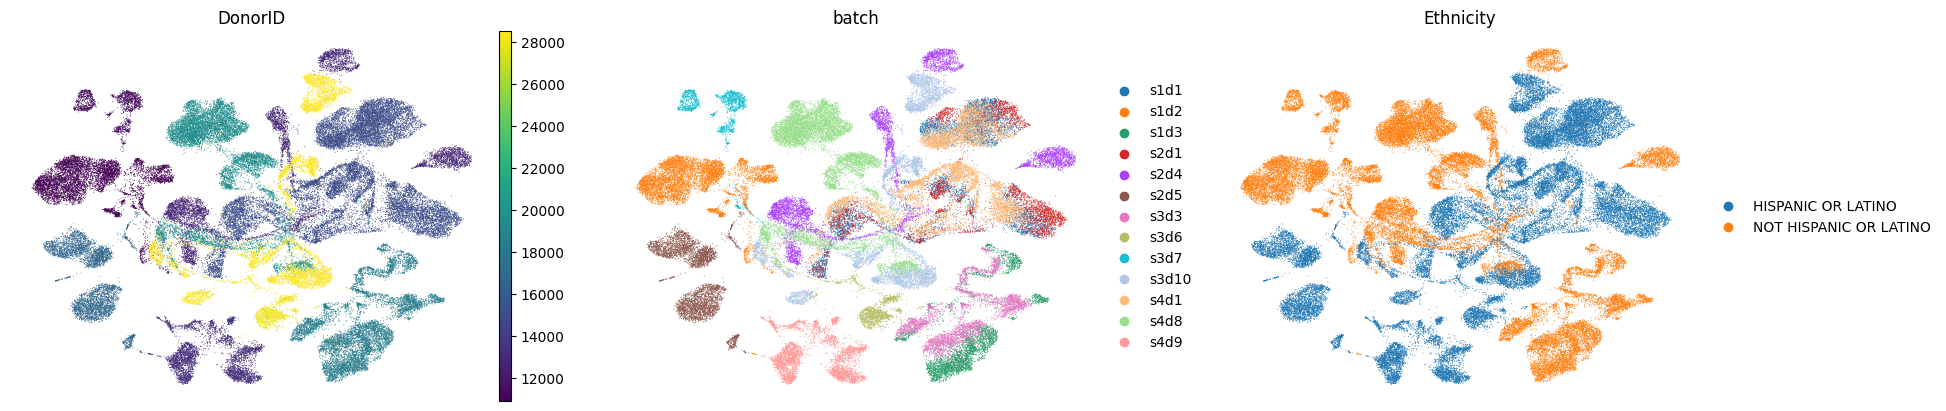

---UMAP for dis2p_Z_2_gex ---


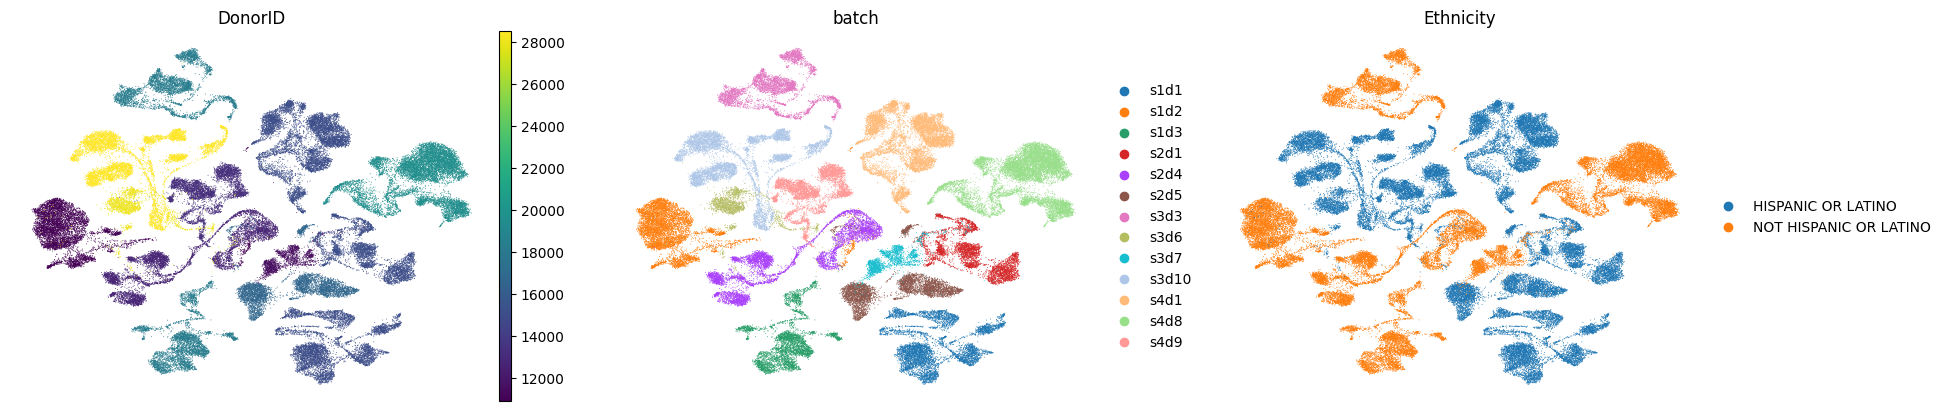

---UMAP for dis2p_Z_3_gex ---


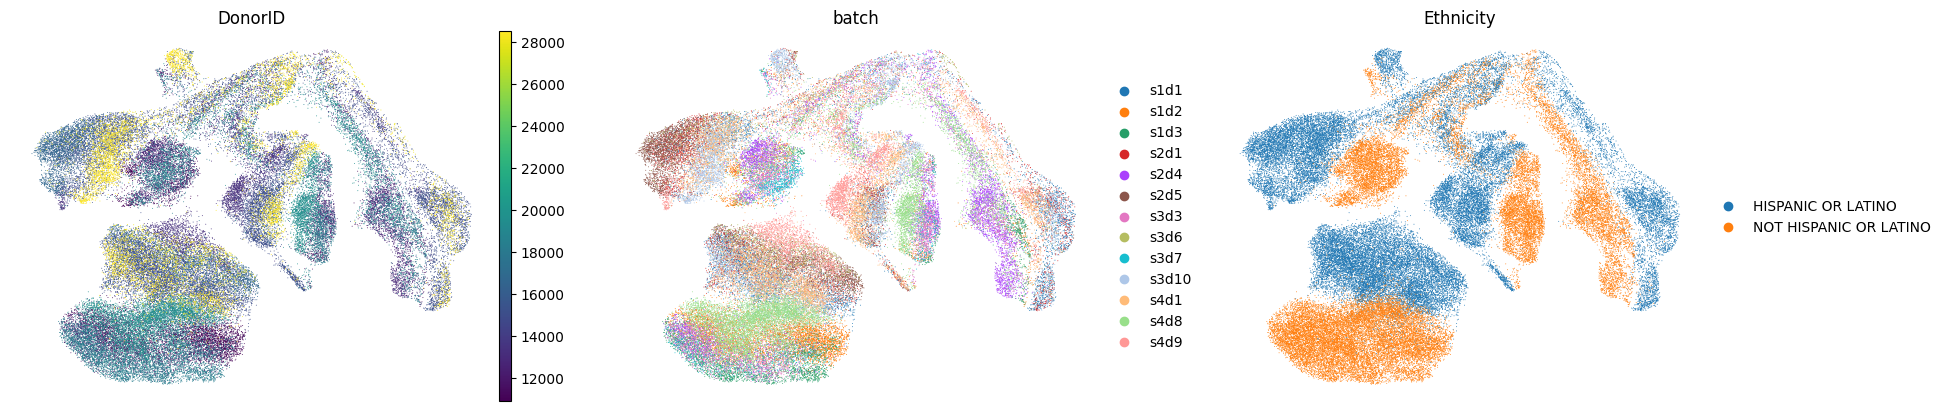

In [31]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}_gex'

    print(f"---UMAP for {latent_name} ---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )